# Restaurant Recommender System

**Authors**: Lyla Kiratiwudhikul, Mina Lee, Tom Zhang

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from surprise import Dataset, Reader, KNNWithMeans # pip install scikit-surprise
from surprise.model_selection import GridSearchCV

## Motivations and Objectives

For the past few decades, with the fast growing market of digital platforms, 
companies have tried to customize the advertising of their products based on individual customers' preferences or interests. 
This practice has been utilized across various industries and companies, from the e-commerce site Amazon suggesting relevant products to the streaming platform Netflix recommending similar shows to their users' view history and profile. The recommendation systems help increase sales as the users are able to easily see and purchase recommended products that match their needs and preferences.

In this project, we focus on devising a restaurant recommendation system (hereby referred to as “recommender”).
We use data of restaurants and customer profiles from Yelp, a platform for crowd-sourced reviews about businesses.
As an individual has unique restaurant preferences, such as cuisines, ambience, pets, diet types, and/or parking availability, we aim to build the recommender to recommend restaurants to users based on the insights gleaned from their reviews on the previous restaurants they have been to.

## Data Overview

The data is downloaded from [Yelp official website](https://www.yelp.com/dataset/documentation/main). There are two datasets relevant to our analysis and models: `business` and `review` data. The `business` dataset contains information about the businesses including name, location, hours, average rating stars, hours, number of reviews, and other features such as cuisine types and parking availability. The `review` dataset records full review text data as well as the `user_id` who wrote the review and the `business_id` for which the review was written. There are 150,346 businesses and 6,990,280 reviews in the Yelp original datasets. Below is the list of features in the two raw datasets:

**Business:**
- `business_id`: business’s ID, string
- `name`: business’s name, string
- `address`: business’s full address, string
- `city`: business’s city, string
- `state`: business’s state, string, 2 character state code, if applicable
- `postal_code`: business’s postal code, string
- `latitude`: business’s latitude, float
- `longitude`: business’s longitude, float
- `stars`: business’s average stars rating, float (ranging from 1 to 5, with 0.5 increment)
- `review_count`: business’s number of reviews, integer
- `is_open`	: whether the business is open or closed; 0 or 1 for closed or open, integer
- `attributes`: business’s features (e.g whether it offers parking, whether it accept credit cards, etc), JSON object
- `categories`: business’s categories (e.g. “Mexican”, “Burger”, etc), array of strings
- `hours`: business’s working hours, object of key day (Monday-Sunday) to value hours

**Review:**
- `review_id`: unique review ID, string
- `user_id`: 22 character user’s ID, string
- `business_id`: 22 character business’s ID, string
- `stars`: business’s stars rating, integer (1 to 5)
- `useful`: number of useful votes received, integer
- `integer`: number of funny votes received, integer
- `cool`: number of cool votes received, integer	
- `text`: review itself, string
- `date`: date format YYYY-MM-DD, string





### Data Preparation

**Business:**

As the main goal of this project is to build a recommender system that suggests top restaurants and their offerings based on user location, we have excluded the entries that are not classified as restaurants such as “spas”, “hotels”, and “hair salons” by dropping all rows whose `categories` do not contain any of the following keywords: “food”, “restaurant”, “bar”, “pubs”, “restaurant”, “tea”, and “coffee”. This has decreased the number of entries from 150,346 to 69,253.

Further, we have expanded `attributes` columns based on the JSON objects given. The first attempt returned 39 new columns. However, some of the expanded features contained nested JSON objects, so we further expanded `BusinessParking`, `Ambience`, `DietaryRestrictons`, and `Music` features and concatenated them to the other attributes, resulting in final 62 columns.

In addition, the missing values in original and newly created attributes based features are filled with `None`, indicating that the information is not available. We decided to impute the missing values this way instead of mode imputation method because there are users who might be indifferent regarding the missing attributes and those who are concerned about them (e.g. whether there is parking or not).

For `hours`, an expansion of operating hour objects into seven days was performed first. For the 9,710 missing entries for hours, we imputed the operating hours with the modes of the dataset for businesses whose value for the hours column was completely missing and imputed with `"closed"` for businesses whose hours are available for only some days and are not provided for the other days (i.e. we assumed that these restaurants are closed on the missing days).

Furthermore, there are a few states that have only one business in our dataset, which are not suitable for our recommender task, and we have, thus, decided to drop these states with only one business: North Carolina, Colorado, Hawaii, Montana, and South Dakota.

The final dataset for the business records has a total of 84 features with 68,054 entries. The business dataset has a total of five numeric features (`latitude`, `longitude`, `stars`, `review_count`, `is_open`). However, since `is_open` is a binary feature and `latitude` and `longitude` are useful in their original states. Only `stars` and `review_count` have been standardized to prevent any potential bias from large scales.


**Review:**

For the review dataset, we have first filtered the dataset in accordance with the business dataset by filtering out reviews for irrelevant businesses (using `business_id`) that have been pre-processed out as described above. This has reduced the size of the review dataset from 6,990,280 to 5,257,329 entries. Since the review dataset do not have missing entries, no imputation or dropping related to missing values have been conducted. However, we have decided to standardize the numeric features (`stars`, `useful`, `funny`, `cool`) in the review dataset to prevent any larger scales dominating the analysis and leading to a biased result.

Note: the code for data preparation can be found in `business_dat_inspect.ipynb` and `review_data_inspect.ipynb`.

## Exploratory Data Analysis

After cleaning the business data as described above, there are 68,054 restaurant-type businesses and 5,257,329 user reviews left in the datasets. Figure 1 shows that the restaurants in the dataset are located in 12 states with over 23% of them in Pennsylvania.

<figure>
<figcaption><strong>Figure 1</strong></figcaption>
<img src="Figures/map_numrecords_by_state.png"  width="700">
</figure>

The average star (a rating ranging from 1 to 5 with 0.5 increment) of these restaurants is approximately 3.6 with around 75 reviews for each restaurant. 

In [3]:
busi_df = pd.read_feather("data/yelp_business_cleaned.feather")
print(f"There are {busi_df.shape[0]} business records with {busi_df.shape[1]} total features.")
display(busi_df.head(3))
busi_df[['stars', 'review_count']].describe()

There are 68054 business records with 84 total features.


,original_index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,music_live,music_video,music_karaoke,hours_Monday,hours_Tuesday,hours_Wednesday,hours_Thursday,hours_Friday,hours_Saturday,hours_Sunday
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,None,None,None,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,...,None,None,None,closed,closed,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,...,None,None,None,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0


,stars,review_count
count,68054.000000,68054.000000
mean,3.563949,74.619861
std,0.851437,169.900997
min,1.000000,5.000000
25%,3.000000,11.000000
50%,3.500000,27.000000
75%,4.000000,73.000000
max,5.000000,7568.000000


When looking at the distribution of rating stars, it is slightly left skewed with mode at $4.0$. On the other hand, the highly right skewed distribution of the number of reviews shown below indicates that a small number of restaurants are more popular than the others and have more reviews.

Text(0, 0.5, 'Number of restaurants')

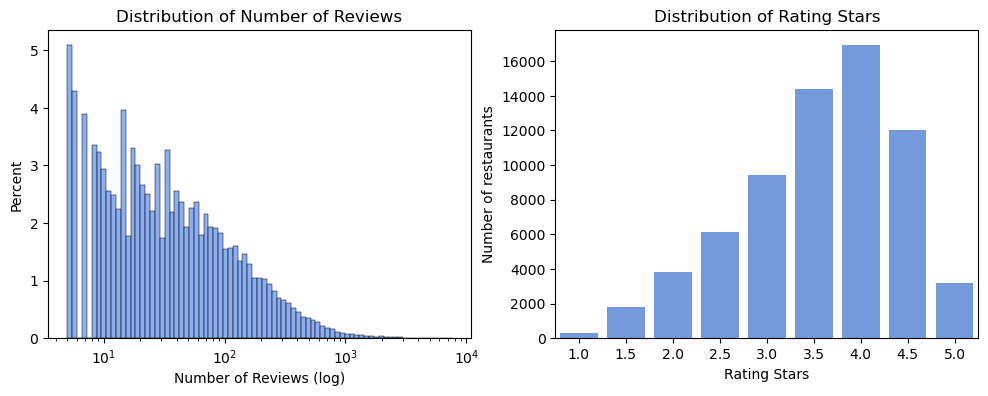

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(data = busi_df, x = 'review_count', 
             color = 'cornflowerblue', stat = 'percent',
             log_scale = True, ax = ax[0])
ax[0].set_title("Distribution of Number of Reviews")
ax[0].set_xlabel("Number of Reviews (log)")

sns.barplot(data = busi_df.groupby(['stars'])[['business_id']].agg('count').reset_index().astype({'stars': str}),
            x = 'stars', 
            y = 'business_id',
            color = 'cornflowerblue', ax = ax[1])
ax[1].set_title("Distribution of Rating Stars")
ax[1].set_xlabel("Rating Stars")
ax[1].set_ylabel("Number of restaurants")

Still, not all of the restaurants in the dataset are still in operation. About 30% of the businesses have been closed. This fact has an important implication for our recommender system. We may use data from restaurants that are now closed during training to gain more insights into what users like and dislike. However, we will not recommend users to a closed restaurant. 

Text(0, 0.5, 'Percentage (%)')

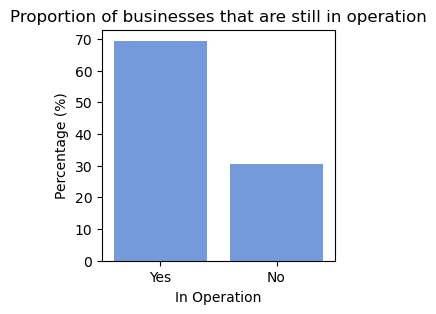

In [12]:
# proportion of businesses that are still in operation
in_oper = busi_df['is_open'].value_counts(normalize = True, sort = True, dropna = False)
in_oper = in_oper.to_frame().reset_index()
in_oper.rename(columns = {'is_open': 'proportion', 'index' : 'in operation'}, inplace = True)
in_oper['in operation'] = in_oper['in operation'].map({1: "Yes", 0: "No"})
in_oper['proportion'] = in_oper['proportion'] * 100

fig, ax = plt.subplots(figsize = (3, 3))
sns.barplot(data = in_oper,
            x = 'in operation', y = "proportion", 
            order = ['Yes', 'No'],
            color = "cornflowerblue")
plt.title("Proportion of businesses that are still in operation")
plt.xlabel("In Operation")
plt.ylabel("Percentage (%)")

The following describes some characteristics of the restaurants in the dataset that users might weigh when choosing a restaurant and hence might be a critical aspect for our recommender system: 
- More than half of the restaurants price their services below $30 and there are a small number of high-end restaurants (pricing over $61).
- In addition, for customers who have cars, over 60 percent of the restaurants indicate that they have at least one parking option (e.g. on street, parking lots, valet, etc.). 
- We believe that certain users have dietary restrictions and so we look at the special diet types that restaurants offer. The data shows that more than $99\%$ of restaurants do not indicate their dietary accommodations on Yelp. Yet, for those whom we do have data, gluten-free, vegetarian, and vegan are the top 3 most available options. 
- There are only about $5\%$ of restaurants that are dog-friendly. This feature might be important for dog owners who want to eat out and bring their dogs with them. 

Regardless, we must use these characteristics with caution as the information for the majority of businesses on our dataset is not available.


Text(0, 0.5, 'Percentage (%)')

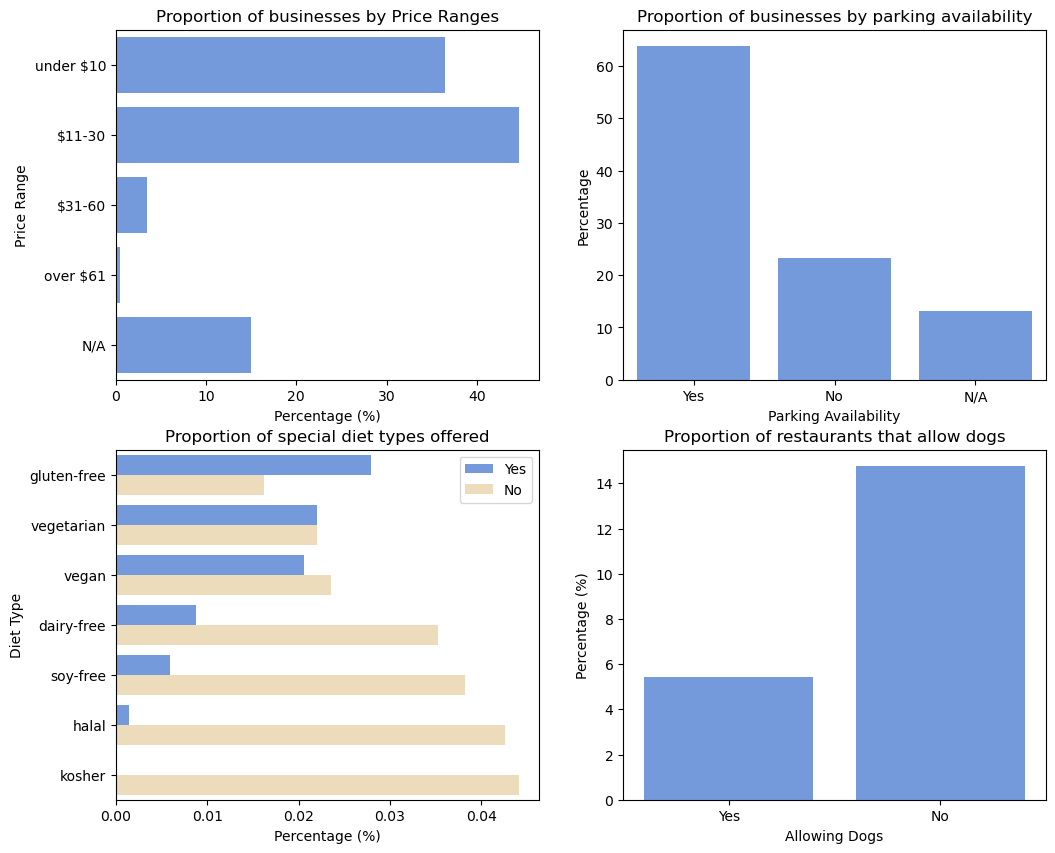

In [35]:
### Price ranges
label_map = {"1": "under $10",
             "2": "$11-30",
             "3": "$31-60",
             "4": "over $61",
             "None": "N/A"}
priceranges = busi_df['RestaurantsPriceRange2'].map(label_map).value_counts(normalize = True, sort = True, dropna = False)
priceranges = priceranges.to_frame().reset_index()
priceranges.rename(columns = {'RestaurantsPriceRange2': 'proportion', 'index' : 'price range'}, inplace = True)
priceranges['proportion'] = priceranges['proportion'] * 100
# priceranges

busi_df['has_parking'] = busi_df[['parking_garage', 'parking_street', 
                        'parking_validated', 'parking_lot', 
                        'parking_valet']].replace({"None": np.nan,
                                                "True": 1, 
                                                "False": 0}).max(axis = 1)
parking_stat = busi_df['has_parking'].value_counts(dropna = False, normalize = True).to_frame().reset_index()
parking_stat.rename(columns = {'has_parking': 'proportion', 'index' : 'has_parking'}, inplace = True)
parking_stat['has_parking'] = parking_stat['has_parking'].map({1: "Yes", 0: "No"})
parking_stat['has_parking'].fillna("N/A", inplace = True)
parking_stat['proportion'] = parking_stat['proportion'] * 100
# parking_stat

diets = busi_df[['diet_dairy-free', 'diet_gluten-free',
                'diet_vegan', 'diet_kosher',
                'diet_halal', 'diet_soy-free',
                'diet_vegetarian']].replace({"None": np.nan,
                                        "True": 1, 
                                        "False": 0})
val_count_list = []
for d in list(diets.columns):
    count = diets[d].value_counts(dropna = False, normalize = True).to_frame()
    val_count_list.append(count)
diets_counts = pd.concat(val_count_list, axis = 1)
diets_counts.reset_index(inplace = True)
diets_counts['index'] = diets_counts['index'].map({1: "Yes", 0: "No"})
diets_counts['index'].fillna("N/A", inplace = True)
diets_counts = diets_counts.melt(id_vars = ['index'], 
                                 var_name = "diet type",
                                 value_name = 'proportion'
                                 )
diets_counts = diets_counts[diets_counts['index'] != "N/A"]
diets_counts['proportion'] = diets_counts['proportion'] * 100
diets_counts['diet type'] = diets_counts['diet type'].str.replace("diet_", "")
diets_counts.sort_values(["index", "proportion"], ascending = [False, False], inplace = True)
# diets_counts

dog_allow = busi_df['DogsAllowed'].value_counts(normalize = True, sort = True, dropna = False)
dog_allow = dog_allow.to_frame().reset_index()
dog_allow.rename(columns = {'DogsAllowed': 'proportion', 'index' : 'Allowing dogs'}, inplace = True)
dog_allow['Allowing dogs'] = dog_allow['Allowing dogs'].map({"True": "Yes", "False": "No", "None": "N/A"})
dog_allow['proportion'] = dog_allow['proportion'] * 100
# dog_allow


fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax = ax.ravel()
sns.barplot(data = priceranges,
            y = 'price range', x = "proportion", 
            order = ["under $10", "$11-30", "$31-60", "over $61", "N/A"],
            color = "cornflowerblue", ax = ax[0])
ax[0].set_title("Proportion of businesses by Price Ranges")
ax[0].set_ylabel("Price Range")
ax[0].set_xlabel("Percentage (%)")

sns.barplot(data = parking_stat,
            x = 'has_parking', y = "proportion",
            color = "cornflowerblue", ax = ax[1])
ax[1].set_title("Proportion of businesses by parking availability")
ax[1].set_xlabel("Parking Availability")
ax[1].set_ylabel("Percentage")

sns.barplot(data = diets_counts,
            x = 'proportion', y = "diet type",
            hue = 'index',
            palette = ["cornflowerblue", "wheat"], ax = ax[2])
ax[2].set_title("Proportion of special diet types offered")
ax[2].set_xlabel("Percentage (%)")
ax[2].set_ylabel("Diet Type")
ax[2].legend(title = "")

sns.barplot(data = dog_allow[dog_allow['Allowing dogs'] != "N/A"],
            x = 'Allowing dogs', y = "proportion", 
            order = ['Yes', 'No'],
            color = "cornflowerblue", ax = ax[3])
ax[3].set_title("Proportion of restaurants that allow dogs")
ax[3].set_xlabel("Allowing Dogs")
ax[3].set_ylabel("Percentage (%)")

As for the 5,257,329 user review data, the average of all standardized numeric variables ('stars', 'useful','funny','cool') are all close to 0. The only numerical distinction between these features are that they have distinct minimum and maximum values. This might be due to the overall distribution of each numerical value being extremely right skewed, meaning that only a few reviews have received high numbers of useful, funny, and cool votes from other users. 

In [3]:
df_re = pd.read_feather("data/yelp_review_cleaned.feather")
print(f"There are {df_re.shape[0]} review records with {df_re.shape[1]} total features.")
df_re.head(3)
df_re[['stars', 'useful','funny','cool']].describe()

There are 5257329 review records with 9 total features.


,stars,useful,funny,cool
count,5.257329e+06,5.257329e+06,5.257329e+06,5.257329e+06
mean,1.150474e-13,3.171765e-13,-1.903410e-13,-1.795072e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.012361e+00,-7.241003e-01,-7.627253e-01,-6.830580e-01
25%,-5.771139e-01,-3.659604e-01,-1.843155e-01,-2.294381e-01
50%,1.405098e-01,-3.659604e-01,-1.843155e-01,-2.294381e-01
75%,8.581335e-01,-7.820544e-03,-1.843155e-01,-2.294381e-01
max,8.581335e-01,1.500528e+02,4.579163e+02,1.830330e+02


In [5]:
mean_stars = df_re["stars"].mean() 
mean_useful = df_re["useful"].mean()
mean_funny = df_re['funny'].mean()
mean_cool = df_re['cool'].mean()

min_stars = df_re['stars'].min()
min_useful = df_re['useful'].min()
min_funny = df_re['funny'].min()
min_cool = df_re['cool'].min()

max_stars = df_re['stars'].max()
max_useful = df_re['useful'].max()
max_funny = df_re['funny'].max()
max_cool = df_re['cool'].max()

print(
    "\n"
    f"The mean stars is {mean_stars:.4f} \n"
    f"The mean number of useful is {mean_useful:.4f} \n"
    f"The mean number of funny is {mean_funny:.4f} \n"
    f"The mean number of cool is {mean_cool:.4f} \n"
    f"The minimum and maximum values of stars is {min_stars:.4f} and {max_stars:.4f}\n"
    f"The minimum and maximum values of useful is {min_useful:.4f} and {max_useful:.4f}\n"
    f"The minimum and maximum values of funny is {min_funny:.4f} and {max_funny:.4f}\n"
    f"The minimum and maximum values of cool is {min_cool:.4f} and {max_cool:.4f}"
)


The mean stars is 0.0000 
The mean number of useful is 0.0000 
The mean number of funny is -0.0000 
The mean number of cool is -0.0000 
The minimum and maximum values of stars is -2.0124 and 0.8581
The minimum and maximum values of useful is -0.7241 and 150.0528
The minimum and maximum values of funny is -0.7627 and 457.9163
The minimum and maximum values of cool is -0.6831 and 183.0330


Since `useful`, `funny`, `cool` features represent number of designated votes, we may notice that these numeric are correlated. From the correlation plot, `useful` and `cool` seem to be more correlated than other features and `stars` have little correlations with three other variables.

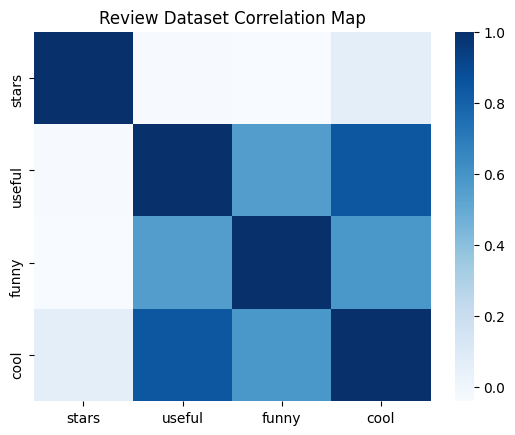

In [7]:
cor = df_re.corr()
sns.heatmap(cor, cmap = 'Blues')
plt.title("Review Dataset Correlation Map")
plt.show()

Below figures are to check the distribution of reviews by business, users, and states. Below figures have been investigated by counting the numbers of reviews by distinct user_id and by state on corresponding the business_id after merging the columns of state, city, name, for the business dataset (i.e. restaurants). By doing this, we can understand that there is an imbalance for the review dataset since some users have written more reviews than other users and some restaurants have received much larger quantities of reviews than others. 

Following information have been obtained from the plots:
* A total of 1,532,233 users have written the 5,257,329 reviews on business in the dataset. 
* There are 76,869 users who have written more than 10 reviews on businesses. 
* Pennsylvania has the largest amount of reviews from the user on business whereas Illinois has the smallest amount of reviews among the states we have in the dataset.

#### by business

There are 68054 business received reviews.


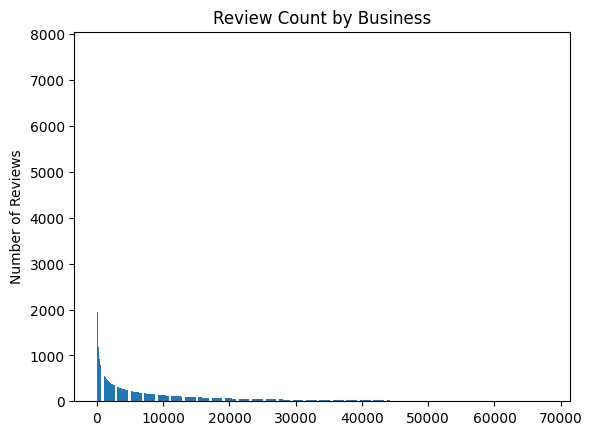

In [9]:
# group by unique business id
review_count_by_business = df_re.groupby('business_id')['review_id'].count().sort_values(ascending=False)
plt.bar(np.arange(review_count_by_business.shape[0]), review_count_by_business);
plt.title('Review Count by Business')
plt.ylabel('Number of Reviews')
print(f"There are {len(review_count_by_business)} business received reviews.")
plt.show()

#### by states

There are 5257329 review records with 12 total features.


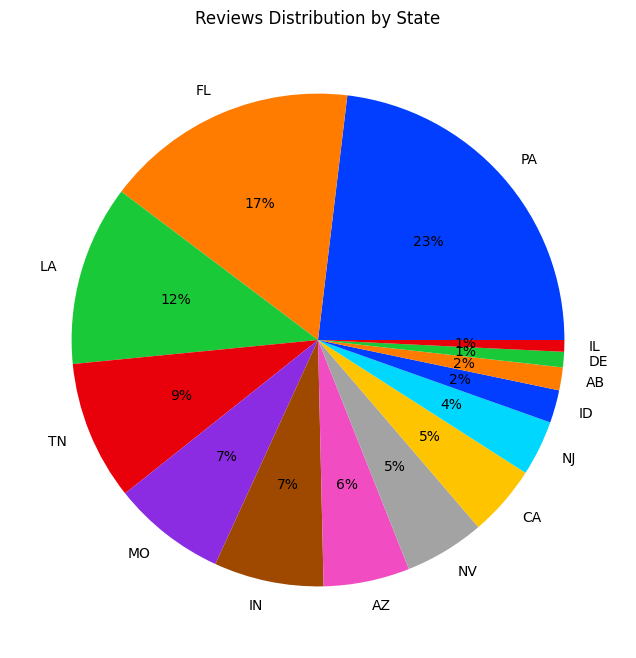

In [11]:
# merge business dataset to get state, city, name
business = pd.read_feather("data/yelp_business_cleaned.feather")
merge = pd.merge(df_re, business, on='business_id', how='outer')
merge = merge[['review_id', 'user_id', 'business_id', 'text', 'date', 'stars_x',
       'useful', 'funny', 'cool','state','city','name']].rename(columns={'stars_x':'stars'})
print(f"There are {merge.shape[0]} review records with {merge.shape[1]} total features.")

# group by state in descending order
state_count_by_business = merge.groupby('state')['business_id'].count().sort_values(ascending=False)

# Pie plot to see the portion as well
plt.figure(figsize=(10,8))
colors = sns.color_palette('bright')[0:14]
plt.pie(state_count_by_business.array, labels=state_count_by_business.index, colors = colors, autopct='%.0f%%')
plt.title("Reviews Distribution by State")
plt.show()

#### by users

1532233 users have written the 5257329 reviews on business in the dataset.
There are 76869 users who have written more than 10 reviews on businesses.


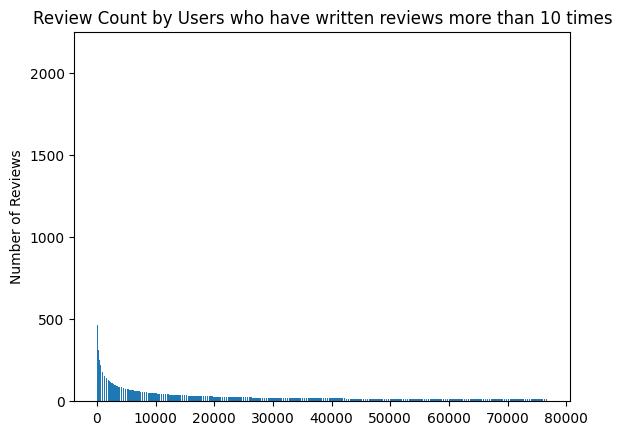

In [12]:
# group by user id in descending order
user_count = merge.groupby(by=["user_id"])['business_id'].count().sort_values(ascending=False)
# checking unique users
print(f"{len(user_count)} users have written the {merge.shape[0]} reviews on business in the dataset.")

# checking unique users with more than 10 reviews written
user_count = user_count.to_frame()
users_aboveten = user_count[user_count['business_id'] > 10]['business_id']
print(f"There are {users_aboveten.shape[0]} users who have written more than 10 reviews on businesses.")

# Plot the counts of reviews by users
plt.bar(np.arange(users_aboveten.shape[0]), users_aboveten);
plt.title('Review Count by Users who have written reviews more than 10 times')
plt.ylabel('Number of Reviews')
plt.show()

There is an obvious imbalance in the review dataset. However, mitigating class imbalance in this dataset can be considered improper since the number of reviews could be an indicator for the business’s popularity. Based on this assumption, both under-sampling of restaurants with more reviews and over-sampling (e.g. SMOTE) of restaurants with less reviews are inappropriate. Due to this reason, the class imbalance has been preserved for the review dataset.

## Baseline Model

There are multiple ways to implement a recommendation system:

- collaborative filtering
- content-based filtering
- hybrid

In particular, collaborative filtering can be further divided into two types (a hyper-parameter):

- user-based: find similar users based on ratings a user gave out
- item-based: find similar items based on ratings given to an item

In either case, the algorithm relies on a user-item matrix, in which the rows match the users and columns the items. From here, we can then make predictions after calculating similarities amongst the users or items. This is known as a memory-based approach. If we apply an extra step to reduce the sparse user-item matrix with matrix factorization, this would be called a model-based approach.

For our baseline model, we will implement the memory-based collaborative filtering technique.

We also need to install `scikit-surprise`, a recommendation system package: `pip install scikit-surprise`. One of its functions `KNNWithMeans` would be particularly useful here. It is a basic collaborative filtering algorithm, taking into account the mean ratings of each user.

## Prep Data

We require a data frame with 3 columns: user, item, rating; with each row corresponding to a user's rating for a particular restaurant.

In [2]:
review_df = pd.read_feather('data/yelp_review_cleaned.feather')

In [3]:
df = review_df.loc[:, ['user_id', 'business_id', 'stars']]

Note that we previously scaled `stars`, so we will now un-scale it as we're now using it as our response:

In [4]:
stars_scaled_unique = sorted(list(df['stars'].unique()))

In [5]:
stars_scale_map = dict(list(zip(stars_scaled_unique, range(1, 6))))
stars_scale_map

{-2.0123613662910693: 1,
 -1.2947376560318022: 2,
 -0.5771139457725354: 3,
 0.1405097644867315: 4,
 0.8581334747459984: 5}

In [6]:
df['stars'] = df['stars'].map(stars_scale_map)

In [7]:
df.stars.unique()

array([3, 5, 4, 1, 2])

We will take a smaller random sample out of concerns for the hardware:

In [8]:
df.shape

(5257329, 3)

In [9]:
sub = df.sample(10000, random_state=42)

In [10]:
sub.head()

,user_id,business_id,stars
1322294,0lpxU4Dfi8AeBt0SeCrEuw,tQKqrLs16Xi-lFrd3_CBAQ,1
4297632,5nw1Zc3fi_ehDJFd3mUEYA,nLxNJuvgoHQHn_IGYifRnw,1
2143059,7fDqaGdUMccXQ4bnPwR6yg,etaIhl-sduOKc6J_qHmmtA,3
3068250,GyFJNSJjI5aWww-D0Btcbw,GlKffg2PMtzByocI5OHIQA,3
1371839,o66iBwIWxfWPypnqfrHVNw,XVFUNtPWYpxhoWPtBQHFdQ,2


## Build Recommender

Test: Collaborative filtering (item-based matrix, memory-based method, cosine-similarity):

In [11]:
# load in data into scikit-surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sub, reader)

In [12]:
# configs
sim_options = {
    "name": "cosine",  # to use item-based cosine similarity
    "user_based": False,  # Compute similarities between items
}

algo = KNNWithMeans(sim_options=sim_options)

In [13]:
trainingSet = data.build_full_trainset()

In [14]:
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
prediction = algo.predict(sub.iloc[4, 0], sub.iloc[4, 1])
prediction.est

2.0

Now incorporate hyper-parameter tuning with grid search:

In [16]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

In [17]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [22]:
print(f'best rmse: {gs.best_score["rmse"]}')
print(f'best params: {gs.best_params["rmse"]}')

best rmse: 1.4087381876138967
best params: {'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}


## Up Next

- Test model-based approach in collaborative filtering
- Test content-based recommenders
- Use more complex models such as neural networks rather than just cosine similarities